# 大作业：雾霾数据爬取与分析

## Step I: get_aqi

- [空气质量数据来源](https://www.aqistudy.cn/historydata/)
- [数据所在地址](https://www.aqistudy.cn/historydata//daydata.php?city=北京&month=201402)

In [1]:
import os

_PATH = './historyaqi/'
os.makedirs(_PATH, exist_ok=True)

In [2]:
def progressbar(cur, total, msg):
    """显示进度条"""
    import math
    percent = '{:.2%}'.format(cur / total)
    lth = int(math.floor(cur * 25 / total))
    print("\r[%-25s] %s (%d/%d)" % ('=' * lth, percent, cur, total) + msg, end='')

def get_renewed_ctx():
    """"""
    import execjs
    node = execjs.get()
    codes =  open('aqiJS-part1.js', encoding='utf8').read()
    codes2 =  open('aqiJS-part2.js', encoding='utf8').read()
    codes3 =  open('aqiJS-part3.js', encoding='utf8').read()
    ctx = node.compile(codes + codes2 + codes3)
    return ctx

def get_historyapi(
    city='北京',
    date_times='201312', 
    url='http://www.aqistudy.cn/historydata/api/historyapi.php',
    ajax_data_key=None, 
    ctx=None, 
    headers=None
) -> dict:
    import requests
    
    if headers is None:
        headers = {
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Encoding': 'gzip, deflate',
            'Accept-Language': 'zh-CN,zh;q=0.8,zh-TW;q=0.7,zh-HK;q=0.5,en-US;q=0.3,en;q=0.2',
            'Content-Type': 'application/x-www-form-urlencoded',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.80 Safari/537.36'
        }
        
    
    temp_text = {}
    if isinstance(date_times, str):
        date_times = [date_times]
    i = 0; Ni = len(date_times)
    for date_time in date_times:
        js = f'getParameter("{city}", "{date_time}")'

        html_info = requests.post(url, 
                                  data={ ajax_data_key: ctx.eval(js) }, 
                                  headers=headers)

        if (len(html_info.text) < 500):
            print('Error:', len(html_info.text), '\n', html_info.text)
            
            return temp_text

        else:
            kw = f'{city}_{date_time}'
            temp_text[kw] = html_info.text
            i += 1; progressbar(i, Ni, msg=kw)
    return temp_text


def save_text2df(
    temp_text: dict, 
    ajax_success_=None,
    ctx=None,
    save_path='./',
    silent=True,
):
    import json
    import pandas as pd
    from tqdm import tqdm
    
    for k, v in tqdm(temp_text.items()):
        js = f'{ajax_success_}("{v}")'

        data = json.loads(ctx.eval(js))
        res = pd.DataFrame(data['result']['data']['items'])
        
        file_path = f'{save_path}/{k}.csv'
        res.to_csv(file_path, index=None)
        if not silent:
            print(f"{len(res)} rows saved in `{save_path}`.")

### **此处需要手动获取密钥/JS函数名称空间**

1. 打开 [网址](https://www.aqistudy.cn/historydata//daydata.php?city=北京&month=202212)，IP未封禁时能看到该城市当月空气质量状况
2. F12 (或 View -> Developer -> Developer Tools) 调试“网络”，刷新页面
3. 控制台报错信息，展开，紧随'showTable', 'eval'后名称最长的函数，所在脚本开头为密钥，复制整段到`aqiJS-part1.js`
4. 新的`aqiJS-part1.js`178行是一个参数为城市+日期的函数，复制函数名，更新到`aqiJS-part3.js`第六行
6. 新的`aqiJS-part1.js`182行data的键值作为下一个Cell内的`ajax_data_key`，186行较长的函数名作为下一个Cell内的`ajax_success_`
5. `aqiJS-part2.js`无需改动，来自独立的解码器js，需要[反混淆](https://worldwebtool.com/javascript-deobfuscator)
6. 如果下一个Cell运行终止，说明密钥已更新，重复上述过程2.-5.

In [3]:
# 手动更新 key 和 函数名
ajax_data_key = 'hFSoYzMbG'
ajax_success_ = 'dJ9wuOlfdQQr'

ctx = get_renewed_ctx()
            
temp_text = get_historyapi(
    city='北京',
    date_times=[f'{year}{month:02d}' 
                for year in range(2022, 2017, -1)
                for month in range(12, 0, -1)],
    ajax_data_key=ajax_data_key, 
    ctx=ctx, 
)
save_text2df(
    temp_text,
    ajax_success_=ajax_success_,
    ctx=ctx,
    save_path=_PATH,
    silent=True,
)

[=========================] 100.00% (60/60)北京_201801

100%|███████████████████████████████████████████| 60/60 [00:06<00:00,  8.77it/s]


## Step II: get_weather


- [风力/风向来源网站](http://tianqi.2345.com)
- [不规范JSON解析矫正](https://jsonlint.com/)
- [参考资料](https://yonniye.com/archives/11.html)


In [4]:
import requests
from tqdm import tqdm
import json

date_times=[f'{year}{month:02d}' 
                for year in range(2018, 2023)
                for month in range(1, 13)]
city_code, city = '54511', '北京'
todo_urls = ["http://tianqi.2345.com/t/wea_history/js/"+
             f"{dt}/{city_code}_{dt}.js" 
             for dt in date_times]

key_strs = ['city', 'tqInfo', 
            'ymd', 'bWendu', 'yWendu',
            'tianqi', 'fengxiang', 'fengli',
            'aqi', 'aqiInfo', 'aqiLevel',
            'maxWendu', 'minWendu', 'avgbWendu', 'avgyWendu',
            'maxAqi', 'minAqi', 'avgAqi', 'avgAqi',
            'maxAqiInfo', 'maxAqiDate', 'maxAqiLevel', 
            'minAqiInfo', 'minAqiDate', 'minAqiLevel']

all_datas = []
for url in tqdm(todo_urls):
    r1 = requests.get(url)
    if r1.status_code != 200:
        print(f'FAIL {url}')
        continue
    js_str = r1.content.decode('gbk')
    js_str = js_str.lstrip('var weather_str=').rstrip(';')
    js_str = js_str.replace("'", '"')
    for k in key_strs:
        js_str = js_str.replace(f",{k}:", f',"{k}":')
        js_str = js_str.replace('{'+f"{k}:", '{'+f'"{k}":')
    tq_info = json.loads(js_str)['tqInfo']
    all_datas.extend([x for x in tq_info if len(x) > 0])

100%|███████████████████████████████████████████| 60/60 [00:13<00:00,  4.55it/s]


In [5]:
import csv

wea_file = f'./weather_{city}.csv'
with open(wea_file, 'w', newline='') as f:
    writer = csv.writer(f)
    cols = ['ymd', 'bWendu', 'yWendu', 'tianqi', 'fengxiang', 'fengli']
    # cols = [c for c in all_datas[0].keys()]
    writer.writerow(cols)
    for dat in all_datas:
        writer.writerow([dat[c] for c in cols])

## Step III: combine_data

In [6]:
import pandas as pd

city = '北京'
tgt_path = f'./data_{city}.csv'
wea_file = f'./weather_{city}.csv'
aqi_path = './historyaqi/'

date_times = [f'{year}{month:02d}' 
              for year in range(2018, 2023)
              for month in range(1, 13)]

aqi = pd.DataFrame()
for dt in date_times:
    aqi = pd.concat(
        [aqi,
         pd.read_csv(f'{aqi_path}/{city}_{dt}.csv')],
        axis=0
    )
# aqi.head(2)

wea = pd.read_csv(wea_file)
# wea = wea.rename(columns={'aqi':'aqi2345'})
# wea.head(2)

wea['date'] = pd.to_datetime(wea['ymd'])
aqi['date'] = pd.to_datetime(aqi['time_point'])
dat = aqi.merge(wea, 
                on=['date'],
                how='left')
dat = dat.set_index('date')
dat = dat[[
    'aqi',
    # 'aqi2345',
    'pm2_5',
    'pm10',
    'so2',
    'no2',
    'co',
    'o3',
    'rank',
    'quality',
    # 'aqiInfo',
    # 'aqiLevel',
    'fengxiang',
    'fengli',
    'bWendu',
    'yWendu',
    'tianqi',
]]
dat.to_csv(tgt_path)
print(tgt_path)
dat.head(2)

./data_北京.csv


,aqi,pm2_5,pm10,so2,no2,co,o3,rank,quality,fengxiang,fengli,bWendu,yWendu,tianqi
date,,,,,,,,,,,,,,
2018-01-01,57,34,63,9,44,1.0,38,84.0,良,东北风,1-2级,3℃,-6℃,晴~多云
2018-01-02,50,28,50,7,33,0.8,46,57.0,优,东北风,1-2级,2℃,-5℃,阴~多云


## Step IV: ana_aqi

In [7]:
import pandas as pd
import sys
sys.path.append('/Users/winston/api_mine/')
from plt_head import *

city = '北京'
src = f'./data_{city}.csv'
dat0 = pd.read_csv(src, index_col=0, parse_dates=True)
dat0.head()

,aqi,pm2_5,pm10,so2,no2,co,o3,rank,quality,fengxiang,fengli,bWendu,yWendu,tianqi
date,,,,,,,,,,,,,,
2018-01-01,57,34,63,9,44,1.0,38,84.0,良,东北风,1-2级,3℃,-6℃,晴~多云
2018-01-02,50,28,50,7,33,0.8,46,57.0,优,东北风,1-2级,2℃,-5℃,阴~多云
2018-01-03,28,11,28,5,21,0.4,51,11.0,优,北风,1-2级,2℃,-5℃,多云
2018-01-04,40,15,30,4,32,0.5,39,118.0,优,东北风,1-2级,0℃,-8℃,阴
2018-01-05,63,32,54,8,50,0.9,36,172.0,良,西北风,1-2级,3℃,-6℃,多云~晴


In [8]:
print(dat0.head().to_markdown())

| date                |   aqi |   pm2_5 |   pm10 |   so2 |   no2 |   co |   o3 |   rank | quality   | fengxiang   | fengli   | bWendu   | yWendu   | tianqi   |
|:--------------------|------:|--------:|-------:|------:|------:|-----:|-----:|-------:|:----------|:------------|:---------|:---------|:---------|:---------|
| 2018-01-01 00:00:00 |    57 |      34 |     63 |     9 |    44 |  1   |   38 |     84 | 良        | 东北风      | 1-2级    | 3℃       | -6℃      | 晴~多云  |
| 2018-01-02 00:00:00 |    50 |      28 |     50 |     7 |    33 |  0.8 |   46 |     57 | 优        | 东北风      | 1-2级    | 2℃       | -5℃      | 阴~多云  |
| 2018-01-03 00:00:00 |    28 |      11 |     28 |     5 |    21 |  0.4 |   51 |     11 | 优        | 北风        | 1-2级    | 2℃       | -5℃      | 多云     |
| 2018-01-04 00:00:00 |    40 |      15 |     30 |     4 |    32 |  0.5 |   39 |    118 | 优        | 东北风      | 1-2级    | 0℃       | -8℃      | 阴       |
| 2018-01-05 00:00:00 |    63 |      32 |     54 |     8 |    50 |  

### 分析雾霾近5年变化趋势

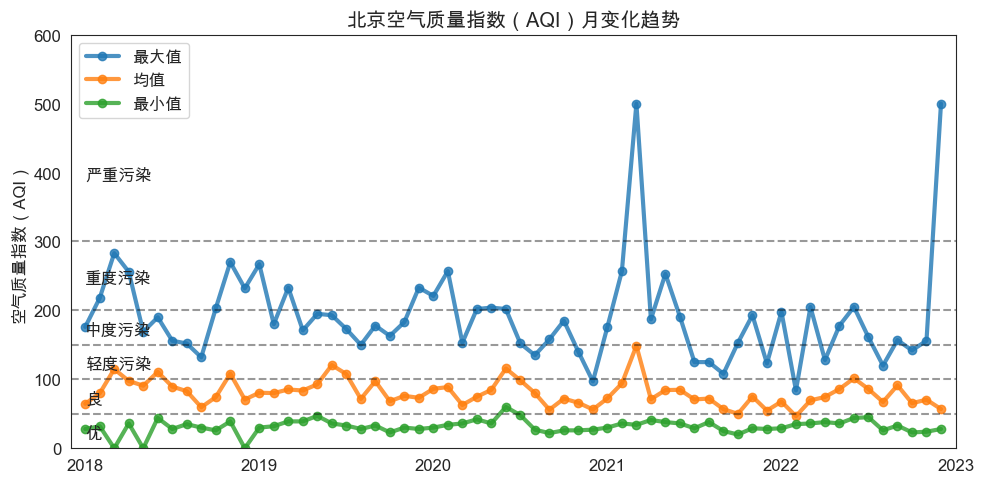

In [9]:
dat = dat0[['aqi', 'quality']].copy().reset_index()
dat['ym'] = dat['date'].apply(lambda x: f'{x.year}-{x.month:02d}-01')
datm = dat.groupby('ym').agg(
    最大值 = ('aqi', 'max'),
    均值 = ('aqi', 'mean'),
    最小值 = ('aqi', 'min'),
)
datm.index = pd.to_datetime(datm.index)
datm.plot(style='o-', linewidth=3, figsize=(10, 5), alpha=.8);
plt.title(f'{city}空气质量指数（AQI）月变化趋势');
plt.xlabel('');
plt.ylabel('空气质量指数（AQI）');
xl, xr = pd.to_datetime('2017-12-01'), pd.to_datetime('2023-01-01')
plt.xlim([xl, xr])
plt.ylim([0,600]);
plt.hlines(y=[300, 200, 150, 100, 50], xmin=xl, xmax=xr, 
           colors='k', alpha=.4, linestyles='--');
plt.text(x=datm.index.min(), y=25-10, s='优');
plt.text(x=datm.index.min(), y=75-10, s='良');
plt.text(x=datm.index.min(), y=125-10, s='轻度污染');
plt.text(x=datm.index.min(), y=175-10, s='中度污染');
plt.text(x=datm.index.min(), y=250-10, s='重度污染');
plt.text(x=datm.index.min(), y=400-10, s='严重污染');
plt.tight_layout();
plt.grid(False);
plt.savefig('figure_1.png', transparent=True);
plt.show();

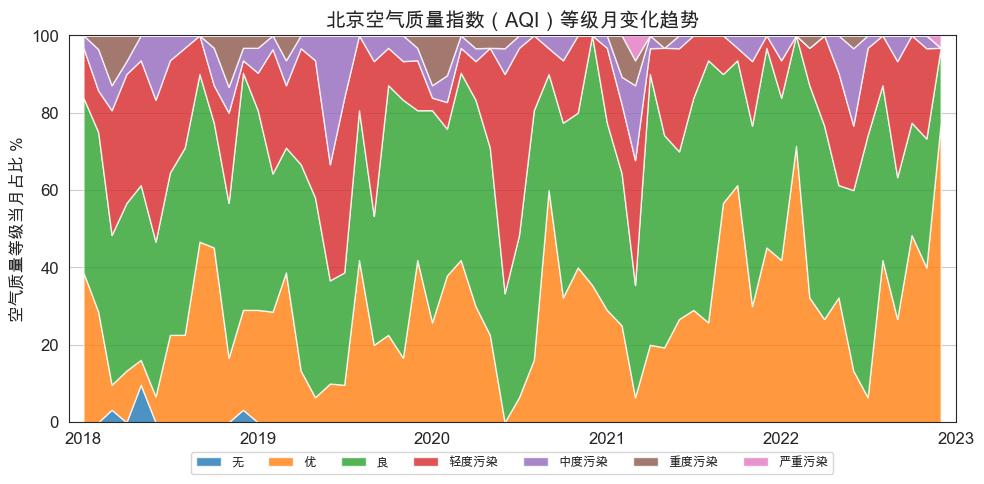

In [10]:
dat = dat0[['aqi', 'quality']].copy().reset_index()
dat['ym'] = pd.to_datetime(
    dat['date'].apply(lambda x: f'{x.year}-{x.month:02d}-01') 
)
for q in ['无', '优', '良', '轻度污染', '中度污染', '重度污染', '严重污染']:
    dat[q] = (dat.quality == q).astype(int)
datm = dat.loc[:, '无':].groupby(dat['ym']).mean() * 100

plt.figure(figsize=(10,5));
plt.stackplot(datm.index, 
              datm['无'], datm['优'], datm['良'], datm['轻度污染'], 
              datm['中度污染'], datm['重度污染'], datm['严重污染'],
              baseline='zero', alpha=.8,
              labels=datm.columns);
plt.legend(loc='lower center', ncol=len(datm.columns),
          bbox_to_anchor=(0.5, -0.15), fontsize=9);
plt.title(f'{city}空气质量指数（AQI）等级月变化趋势');
plt.ylabel('空气质量等级当月占比 %');
xl, xr = pd.to_datetime('2017-12-01'), pd.to_datetime('2023-01-01')
plt.xlim([xl, xr])
plt.ylim([0, 100])
plt.grid(axis='y')
plt.tight_layout();
plt.savefig('./figure_2.png', transparent=True)

### 分析雾霾和风向/风力的关系

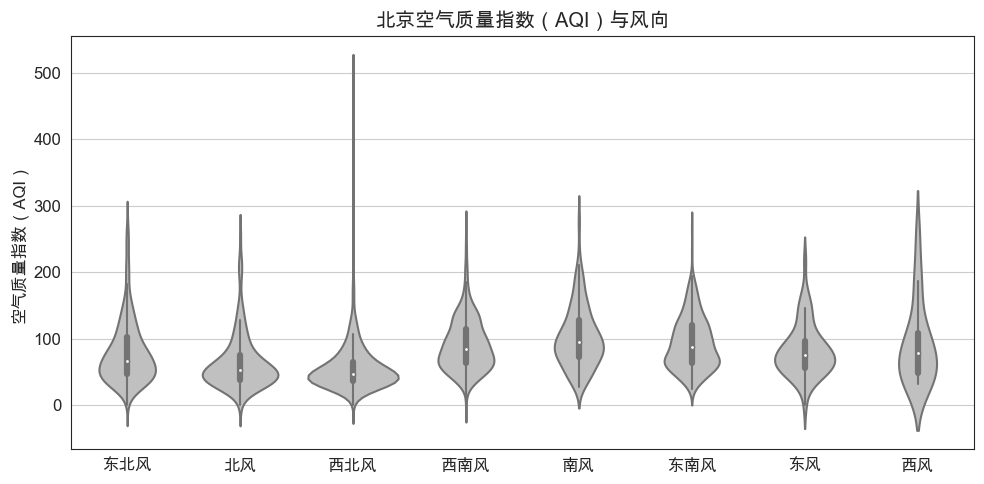

In [11]:
dat = dat0.copy()
plt.figure(figsize=(10,5))
seaborn.violinplot(x='fengxiang', y='aqi', 
                   data=dat, color='silver');
plt.title(f'{city}空气质量指数（AQI）与风向');
plt.xlabel('')
plt.ylabel('空气质量指数（AQI）');
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./figure_3.png', transparent=True)

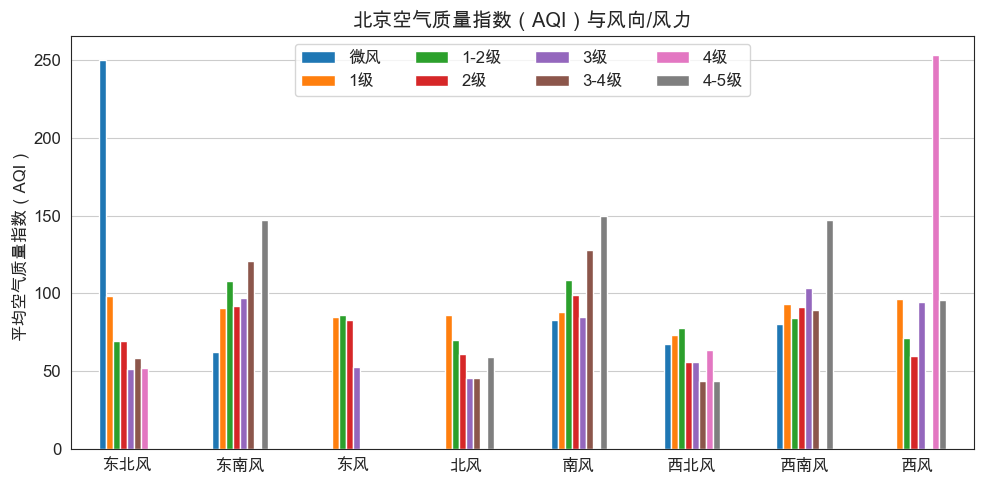

In [12]:
trans_dic = {
    '微风': 0.5,
    '1级': 1, 
    '1-2级': 1.5, 
    '2级': 2, 
    '3级': 3, 
    '3-4级': 3.5, 
    '4级': 4, 
    '4-5级': 4.5, 
}
dat['风力'] = dat['fengli'].apply(lambda x: trans_dic[x])
dat.groupby(['fengxiang', '风力'])['aqi'].mean().unstack().plot(kind='bar', figsize=(10,5));
plt.legend(trans_dic, loc='upper center', ncol=4, fontsize=12)
plt.title(f'{city}空气质量指数（AQI）与风向/风力');
plt.xlabel('')
plt.ylabel('平均空气质量指数（AQI）');
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./figure_4.png', transparent=True)
plt.show();

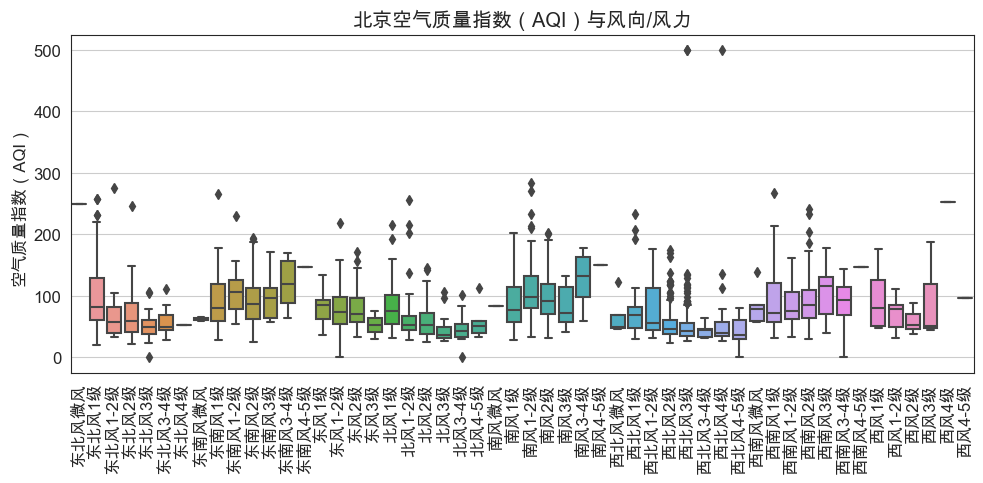

In [13]:
dat['风向/风力'] = dat[['fengxiang', 'fengli']].apply(lambda s: s.iloc[0]+s.iloc[1], axis=1)
dat = dat.sort_values(['fengxiang', '风力'])
plt.figure(figsize=(10,5))
seaborn.boxplot(x='风向/风力', y='aqi', 
                   data=dat);
plt.title(f'{city}空气质量指数（AQI）与风向/风力');
plt.xlabel('')
plt.xticks(rotation=90);
plt.ylabel('空气质量指数（AQI）');
plt.grid(axis='y')
plt.savefig('./figure_5.png', transparent=True)
plt.tight_layout()

In [14]:
%ls

README.md
README.pdf
aqiJS-part1.js
aqiJS-part2.js
aqiJS-part3.js
data_北京.csv
figure_1.png
figure_2.png
figure_3.png
figure_4.png
figure_5.png
historyaqi/
weather_北京.csv
大作业：雾霾数据爬取与分析.html
大作业：雾霾数据爬取与分析.ipynb
